In [271]:
import matplotlib.pyplot as plt
import pandas as pd
import json
import os
import numpy as np
from pathlib import Path  # python3 only
import math,datetime
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
state = 'Texas'
keyword = 'transgender'
year = str(2021)
currentYear = datetime.datetime.now().year


In [272]:
keyWords = ['China','black people','immigrant','muslim','transgender','gay','asian','chinese']
# keyWords = ['asian','chinese']
# keyWords = ['black people','China']
# # keyWords = ['immigrant','transgender','muslim']

In [273]:
averageSentKeyword = {}
mentionsKeyword = {}
# MENTIONSKEYWORD is the frequency of mentions year by year of the given term
startYear = 2010
# Start year is the year you want to begin construction of the graph
yearList = []
for year in range(startYear,currentYear+1):
    year = str(year)
    yearList.append(int(year))
for keyword in keyWords:
    
    averageSentimentOverTime = []
    json_folder = 'Keyword State'
    file_dir = Path.cwd()
    file_path = os.path.join(file_dir, json_folder, (((state) + " on the term " + keyword +'.json')))
    shape_dir = os.path.join(file_dir, 'Shapes', 'United States','USA_Counties.shx')
    # Okay turn the dictionary into a dataframe where one column is filled with keys, and the other column is the first value in the dictionary
    f = open(file_path, 'r')
    state_dict = json.load(f)
    stateDF = pd.DataFrame.from_dict(state_dict, orient='index')
    stateDF.reset_index(inplace=True)
    # stateDF = stateDF[[0,1,2]]
    stateDF.rename(columns={'index': 'County', 0 :'# of Tweets',1:'score',2:'Time'}, inplace=True)
    timeDF = pd.json_normalize(stateDF['Time'])
    stateDF.drop('Time',axis = 1,inplace= True)
    maxCount = timeDF[list(timeDF.filter(regex=('count')))].max().max()
    for year in range(startYear,currentYear+1):
        year = str(year)
        if(len(list(timeDF.filter(regex=year)))>0):
            
            slicetimeDF = timeDF[list(timeDF.filter(regex=('County|' + year+'.comp|' + year+'.count')))]
            county=timeDF[list(timeDF.filter(regex=('County|' + year+'.count')))]
            stateDF = pd.concat([stateDF['County'], slicetimeDF], axis=1)
            stateDF.rename(columns= {stateDF.columns[1]:'# of Tweets',stateDF.columns[2]:'score'}, inplace=True)
            json_folder = 'Keyword State'
            file_dir = Path.cwd()
            file_path = os.path.join(file_dir, json_folder, (((state) + " on the term " + keyword +'.json')))

            # Okay turn the dictionary into a dataframe where one column is filled with keys, and the other column is the first value in the dictionary
            f = open(file_path, 'r')
            score = []
            j=0

            #-------------------------------------
            #-------------------------------------
            # AVERAGE SENT. AND TOTAL POP.
            # get the sum of all values in a column
            totalTweets = stateDF.iloc[:, 1].sum()
            averageSentiment = 0
            k=0
            for score in stateDF['score']:
                if(math.isnan(score)==False):
                    # multiply all values in the score column by the corresponding value in the population column
                    averageSentiment += score * stateDF.iat[k,1]
                k+=1
            averageSentiment=averageSentiment/totalTweets
            
            averageSentimentOverTime.append([averageSentiment,int(year)])
            # Average sentiment overtime is a single index for a specific keyword, which then gets dumped into averageSentKeyword

        
        totalTweets = stateDF.iloc[:, 1].sum()
        if keyword in mentionsKeyword:
            mentionsKeyword[keyword].append([totalTweets,int(year)])
        else:
            mentionsKeyword[keyword] = [[totalTweets,int(year)]]
    
    a, b = zip(*averageSentimentOverTime)
    averageSentKeyword[keyword] = a
    # plt.plot(b,a,label = keyword)

# np.vstack(averageSentimentOverTime,yearList)



SentimentYear = {}
topKeys = averageSentKeyword.keys()
for i in range(len(averageSentKeyword.values())):
    # averageSentKeyword.values()[i]
    sentiment = list(list(averageSentKeyword.values())[i])
    for j in range(len(yearList)):
        if yearList[j] in SentimentYear:
            
            SentimentYear[yearList[j]].append(list(sentiment)[j])
        else:
            SentimentYear[yearList[j]] = [list(sentiment)[j]]
            # Sentiment year is the sorted matrix which is passed through the normalizing function
            # The columns are a measure of the given year
            # The rows are the different keywords
topKeys = list(topKeys)
# normalizedSentiment =  scaler.fit_transform(list(SentimentYear.values()))
NormalizedData =pd.DataFrame(SentimentYear.values(),index=SentimentYear.keys(),columns=topKeys)
# NormalizedData.rename(topKeys,inplace=True)
remappedData = []
for i in range(len(NormalizedData.columns)):
    testData = NormalizedData[[topKeys[i]]].values.tolist()
    a = testData
    a=list(a)
    # a= np.column_stack((a,yearList)).tolist()
    # Merge the list "a" and the liat 'yearList' as if they were two columns in a matrix
    # "a" is a list of n-arrays (each array is a data row), "yearList" is a list of integers

    remappedData.append(list(a))


In [274]:
from scipy.stats.stats import pearsonr
k=0
# The phrases muslim,transgender,and immigrant are STRONGLY correlated, with the max distance between muslim and immigrant,minimum distance between immigrant and transgender
def correlationWords(words):
    word1,word2=words[0],words[1]
    # find the index of word1 in keyWords


    y_1,=zip(*(remappedData[keyWords.index(word1)]))
    
    y_2, = zip(*(remappedData[keyWords.index(word2)]))
    # word1='transgender'
    # word2='immigrant'
    x_2,y = zip(*mentionsKeyword[word1])
    x_1,y = zip(*mentionsKeyword[word2])

    # x_1,=zip(*(remappedData[k]))
    # print(len(list(x_1)))
    # print(len(list(x_2)))
    sentiment=list((pearsonr(x_1,x_2)))
    mentions = list((pearsonr(y_1,y_2)))
    return sentiment,mentions

In [275]:
import itertools
import scipy.stats
keywordPairCombinations = list(itertools.combinations(keyWords, 2))
for pair in keywordPairCombinations:
    sentiment,mentions=correlationWords(pair)
    r_s=round(sentiment[1],5)
    c_s=round(sentiment[0],5)
    r_m = round(mentions[1],5)
    c_m = round(mentions[0],5)
    if r_s<0.05 and r_m<.05:
        r=scipy.stats.combine_pvalues([r_s,r_m], method='fisher', weights=None)
        r=round(r[1],5)
        c=round((c_s+c_m)/2,5)
        print('||'+str(pair[0]) + ' and ' + pair[1] + '||\'s p-val: ' + str(r) + ', correlation: ' + str(c))



||China and black people||'s p-val: 0.0, correlation: 0.93222
||immigrant and transgender||'s p-val: 0.00044, correlation: 0.72153
||muslim and transgender||'s p-val: 0.0002, correlation: 0.7264
||asian and chinese||'s p-val: 4e-05, correlation: 0.78708


||China|| sentiment vs mentions p-val:1e-05 correlation:-0.93006
||Black people|| sentiment vs mentions p-val:0.00056 correlation:-0.84359
||Muslim|| sentiment vs mentions p-val:0.00184 correlation:-0.79873
||Gay|| sentiment vs mentions p-val:0.03731 correlation:-0.60456


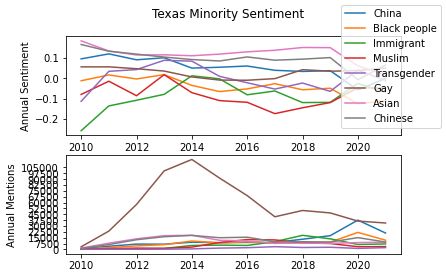

<Figure size 1080x2160 with 0 Axes>

In [276]:
fig, (ax1,ax2) = plt.subplots(2)
fig.suptitle('Texas Minority Sentiment')
ax1.set_ylabel('Annual Sentiment')
ax2.set_ylabel('Annual Mentions')
ax1.set_yticks(np.arange(-.3, .1+.1, .1))
ax2.set_yticks(np.arange(0, 100000+10000, 10000*.75))
for i in range(len(topKeys)):topKeys[i] = topKeys[i].capitalize()
for i in range(len(remappedData)):
    x_2,y = zip(*mentionsKeyword[keyWords[i]])
    x_1,=zip(*(remappedData[i]))
    ax1.plot(yearList,x_1,label = topKeys[i])
    ax2.plot(y,x_2)
    if (pearsonr(x_1,x_2)[1]<.05):
        print('||' + topKeys[i] + '|| sentiment vs mentions p-val:' + str(round(pearsonr(x_1,x_2)[1],5)) + ' correlation:'+ str(round(pearsonr(x_1,x_2)[0],5)))

plt.figure(figsize=(15,30))
fig.legend()

fig.savefig('Texas Cumulitive Minority Analysis.png',dpi = 100,facecolor='w', edgecolor='w',orientation='landscape',transparent=False, bbox_inches='tight', pad_inches=0.1)

